In [ ]:
!pip -q install gymnasium==0.29.1 stable-baselines3==2.3.2 matplotlib==3.9.0

import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# For consistent results
SEED = 42
np.random.seed(SEED)



In [ ]:
class OneDAisleEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self):
        super().__init__()
        # Observation is a single float in [0, 4]
        self.observation_space = spaces.Box(low=0.0, high=4.0, shape=(1,), dtype=np.float32)
        # Two discrete actions: left(0) or right(1)
        self.action_space = spaces.Discrete(2)

        self.start = 0
        self.goal = 4
        self.max_steps = 50

        self.pos = None
        self.steps = 0
        self.reset(seed=SEED)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.pos = int(self.start)
        self.steps = 0
        obs = np.array([self.pos], dtype=np.float32)
        info = {}
        return obs, info

    def step(self, action):
        self.steps += 1

        # Map action to movement: 0 -> -1 (left), 1 -> +1 (right)
        move = -1 if action == 0 else 1
        self.pos = int(np.clip(self.pos + move, 0, 4))

        # Reward design
        done = self.pos == self.goal
        reward = 2.0 if done else -0.05  # small step penalty, terminal bonus on goal

        # Truncation if taking too long (safety)
        truncated = (self.steps >= self.max_steps) and not done

        obs = np.array([self.pos], dtype=np.float32)
        info = {}
        return obs, reward, done, truncated, info


In [ ]:
env_test = OneDAisleEnv()
obs, info = env_test.reset()
print("Initial observation:", obs)
for t in range(6):
    action = 1  # always move right
    obs, r, done, trunc, _ = env_test.step(action)
    print(f"t={t+1}, action=right, pos={int(obs[0])}, reward={r}, done={done}")
    if done or trunc:
        break


Initial observation: [0.]
t=1, action=right, pos=1, reward=-0.05, done=False
t=2, action=right, pos=2, reward=-0.05, done=False
t=3, action=right, pos=3, reward=-0.05, done=False
t=4, action=right, pos=4, reward=2.0, done=True


In [ ]:
from stable_baselines3.common.utils import set_random_seed
set_random_seed(SEED)

raw_env = OneDAisleEnv()
env = Monitor(raw_env)  # logs per-episode stats

class EpisodeRewardCallback(BaseCallback):
    """Collect episode rewards/lengths emitted by Monitor."""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                self.episode_rewards.append(info["episode"]["r"])
                self.episode_lengths.append(info["episode"]["l"])
        return True

reward_cb = EpisodeRewardCallback()


In [ ]:
model = PPO(
    "MlpPolicy",
    env,
    verbose=0,
    seed=SEED,
    n_steps=64,          # short rollouts are fine for tiny envs
    batch_size=64,
    gamma=0.99,
    learning_rate=3e-4
)

TOTAL_STEPS = 2000
model.learn(total_timesteps=TOTAL_STEPS, callback=reward_cb)

print(f"Collected {len(reward_cb.episode_rewards)} complete episodes during training.")
if reward_cb.episode_rewards:
    print("Last 5 episode returns:", reward_cb.episode_rewards[-5:])


Collected 812 complete episodes during training.
Last 5 episode returns: [1.85, 1.85, 1.85, 1.85, 1.85]


In [ ]:
def evaluate(model, episodes=5):
    returns = []
    steps_list = []
    for ep in range(episodes):
        env_eval = OneDAisleEnv()
        obs, info = env_eval.reset()
        done = False
        trunc = False
        ep_ret = 0.0
        steps = 0
        while not (done or trunc):
            action, _ = model.predict(obs, deterministic=True)
            obs, r, done, trunc, _ = env_eval.step(action)
            ep_ret += r
            steps += 1
        returns.append(ep_ret)
        steps_list.append(steps)
        print(f"Eval Episode {ep+1}: return={ep_ret:.2f}, steps={steps}")
    return returns, steps_list

eval_returns, eval_steps = evaluate(model, episodes=5)
print("Average return:", np.mean(eval_returns))
print("Average steps :", np.mean(eval_steps))


Eval Episode 1: return=1.85, steps=4
Eval Episode 2: return=1.85, steps=4
Eval Episode 3: return=1.85, steps=4
Eval Episode 4: return=1.85, steps=4
Eval Episode 5: return=1.85, steps=4
Average return: 1.85
Average steps : 4.0


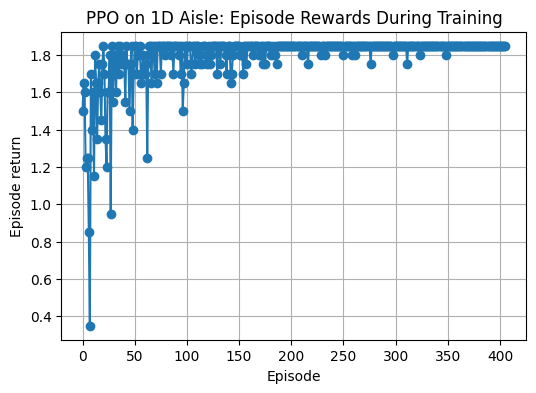

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(reward_cb.episode_rewards, marker='o')
plt.xlabel("Episode")
plt.ylabel("Episode return")
plt.title("PPO on 1D Aisle: Episode Rewards During Training")
plt.grid(True)
plt.show()


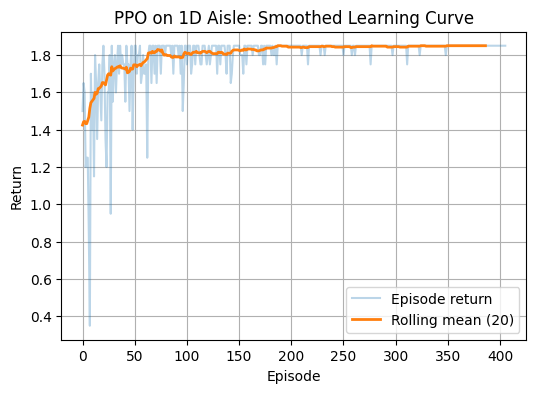

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rewards = np.array(reward_cb.episode_rewards, dtype=float)
window = 20  # moving average window
rolling = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(6,4))
plt.plot(rewards, alpha=0.3, label='Episode return')
plt.plot(rolling, linewidth=2, label=f'Rolling mean ({window})')
plt.xlabel('Episode'); plt.ylabel('Return')
plt.title('PPO on 1D Aisle: Smoothed Learning Curve')
plt.grid(True); plt.legend(); plt.show()